In [4]:
import allel
import numpy as np
import pandas as pd
from functools import reduce
import pprint

In [5]:
merged_df = pd.read_csv("real1_mergered_df.csv",index_col=0)

KeyboardInterrupt: 

In [4]:
merged_df

,CHROM,POS,REF_vs,ALT_1_vs,SSC_vs,SPV_vs,REF_fb,ALT_1_fb,MQMR_fb,MQM_1_fb,...,MQM_3_fb,REF_m2,ALT_1_m2,mQ_m2,MQRankSum_m2,BaseQRankSum_m2,REF_vd,ALT_1_vd,SSF_vd,MSI_vd
0,1,10250,A,NaN,2.0,0.52291,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,10291,C,NaN,2.0,0.60839,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10583,G,NaN,1.0,0.68908,G,NaN,43.0909,41.8400,...,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,0.47730,1.0
3,1,12783,G,NaN,1.0,0.75242,G,NaN,26.5256,24.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,0.48250,1.0
4,1,12817,C,NaN,4.0,0.33043,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,0.40919,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656014,GL000192.1,542751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,1.00000,2.0
4656015,GL000192.1,543455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN,0.49260,1.0
4656016,GL000192.1,544811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,0.03416,3.0
4656017,GL000192.1,544883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,0.37634,1.0


In [6]:
# parse_to_df function takes too long to run so I parse individually 
# try with rand subset of features 
varscan_features = ['CHROM','POS','REF','ALT_1', 'SSC','SPV','is_snp']
real1_varscan_sub = allel.vcf_to_dataframe("real1/real1-varscan.vcf.gz", fields = varscan_features)

freebayes_features = ['CHROM','POS','REF','ALT_1', 'MQMR','MQM','is_snp']
real1_freebayes_sub = allel.vcf_to_dataframe("real1/real1-freebayes.vcf.gz", fields = freebayes_features)

mutect2_features = ['CHROM','POS','REF','ALT_1', 'mQ','MQRankSum','BaseQRankSum','is_snp']
real1_mutect2_sub = allel.vcf_to_dataframe("real1/real1-mutect2.vcf.gz", fields = mutect2_features)

vardict_features = ['CHROM','POS','REF','ALT_1', 'SSF','MSI','is_snp']
real1_vardict_sub = allel.vcf_to_dataframe("real1/real1-vardict.vcf.gz", fields = vardict_features)

/Users/ting/opt/anaconda3/lib/python3.9/site-packages/allel/io/vcf_read.py:1240: UserWarning: 'ALT_1' INFO header not found
  warnings.warn('%r INFO header not found' % name)
/Users/ting/opt/anaconda3/lib/python3.9/site-packages/allel/io/vcf_read.py:1454: UserWarning: no type for field 'variants/ALT_1', assuming object
  warnings.warn('no type for field %r, assuming %s' % (f, normed_types[f]))
/Users/ting/opt/anaconda3/lib/python3.9/site-packages/allel/io/vcf_read.py:1564: UserWarning: no number for field 'variants/ALT_1', assuming 1
  warnings.warn('no number for field %r, assuming 1' % f)


KeyboardInterrupt: 

In [9]:
# subsetting for snp = True 
varscan_sub = real1_varscan_sub[real1_varscan_sub.is_snp == True]
freebayes_sub = real1_freebayes_sub[real1_freebayes_sub.is_snp == True]
mutect2_sub = real1_mutect2_sub[real1_mutect2_sub.is_snp == True]
vardict_sub = real1_vardict_sub[real1_vardict_sub.is_snp == True]

In [ ]:
# Gradient Boosting Decision Trees
# popular algorithms like XGboost and Catboost are examples of using the gradient boosting framework 
# unlike random forests, the decision trees in gradient boosting are built additively; each decision tree is built one after another
# each new treee is built to improve on deficiencies of the previous trees and this concept is called boosting 
# gradient of gradient boosting comes from minimising the gradient of the loss function 

In [10]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy import nan

In [11]:
lst_dfs = [varscan_sub,freebayes_sub,mutect2_sub,vardict_sub]
suffix = ['vs','fb','m2','vd']
keep_same = {'CHROM', 'POS'}
i =0 
for df in lst_dfs:
    df.columns = ['{}{}'.format(c, '' if c in keep_same else '_'+suffix[i]) for c in df.columns]
    i += 1
lst_dfs

[      SOMATIC_vs        ID_vs        SPV_vs  FILTER_PASS_vs       CHROM  \
 7          False  rs199706086  5.229100e-01           False           1   
 8          False  rs145427775  6.083900e-01           False           1   
 10         False   rs58108140  6.890800e-01           False           1   
 11         False   rs62635284  7.524200e-01           False           1   
 12         False            .  3.304300e-01           False           1   
 ...          ...          ...           ...             ...         ...   
 5244       False            .  5.133700e-01           False  GL000192.1   
 5246       False            .  6.664900e-04           False  GL000192.1   
 5247       False            .  2.069300e-04           False  GL000192.1   
 5249       False            .  1.121500e-09           False  GL000192.1   
 5250       False            .  2.301600e-02           False  GL000192.1   
 
          POS  is_snp_vs  
 7      10250       True  
 8      10291       True  
 10  

In [12]:
merged_df = reduce(lambda left, right: pd.merge(left, right,on =['CHROM', 'POS'],
                                            how = 'outer', suffixes = ('', '')),lst_dfs)
merged_df = merged_df.drop(['is_snp_vd','is_snp_fb','is_snp_m2','is_snp_vs'], axis=1)
# okay i shouldnt drop this 
merged_df.to_csv("real1_mergered_df.csv")

In [13]:
from sklearn import datasets
import xgboost as xgb 
from xgboost import XGBClassifier

In [14]:
##  function to get y labels
truth_labels = pd.read_csv("real1/real1_truth.bed", sep = "\t", names = ['Chromo', 'start', 'end'])
print(list(set(truth_labels.start == truth_labels.end) )) # the start and end position are the same 
truth_labels = truth_labels[['Chromo', 'start']]
truth_labels['truth'] = 1
sub_truth= truth_labels.rename(columns = {'Chromo':'CHROM', 'start':'POS'})

[True]


In [15]:
# combine dataset 
combined = merged_df.merge(sub_truth, on=['CHROM','POS'], how = 'left' )
combined['truth'].fillna(0, inplace = True)

In [16]:
combined

,SOMATIC_vs,ID_vs,SPV_vs,FILTER_PASS_vs,CHROM,POS,SOMATIC_fb,QUAL_fb,ID_fb,QR_fb,...,FILTER_t_lod_fstar_m2,HCNT_m2,DP_m2,FILTER_PASS_vd,STATUS_vd,ID_vd,SSF_vd,VD_vd,SOMATIC_vd,truth
0,False,rs199706086,0.52291,False,1,10250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,False,rs145427775,0.60839,False,1,10291,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,False,rs58108140,0.68908,False,1,10583,False,271.100006,rs58108140,1198.0,...,NaN,NaN,NaN,False,Germline,rs58108140,0.47730,11.0,False,0.0
3,False,rs62635284,0.75242,False,1,12783,False,2044.599976,rs62635284,2335.0,...,NaN,NaN,NaN,False,Germline,rs62635284,0.48250,99.0,False,0.0
4,False,.,0.33043,False,1,12817,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,AFDiff,.,0.40919,29.0,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656014,NaN,NaN,NaN,NaN,GL000192.1,542751,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Deletion,.,1.00000,0.0,False,0.0
4656015,NaN,NaN,NaN,NaN,GL000192.1,543455,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,StrongLOH,.,0.49260,0.0,False,0.0
4656016,NaN,NaN,NaN,NaN,GL000192.1,544811,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,StrongLOH,.,0.03416,0.0,False,0.0
4656017,NaN,NaN,NaN,NaN,GL000192.1,544883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Germline,.,0.37634,2.0,False,0.0


In [17]:
X = combined[combined.columns[~combined.columns.isin(['truth','POS','CHROM'])]]

y = combined['truth'] 

In [18]:
# ordinal encoding for REF and ALT
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(X)
new_X = enc.transform(X)

In [19]:
newn_X = pd.DataFrame(new_X, columns = X.columns)

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(newn_X, y, test_size=0.3, random_state = 0 )

In [21]:
# Classifier/Regressor
from xgboost import XGBClassifier, DMatrix
from functools import partial
# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score


In [17]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d = pd.DataFrame(optimizer.cv_results_)
    
    
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [18]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True, 
                      random_state=42)

cv_strategy = list(skf.split(X_train, y_train))

In [19]:
# Setting the basic regressor
clf = XGBClassifier(random_state=0, 
                    booster='gbtree', 
                    eval_metric = 'auc',
                    objective='binary:logistic', 
                    tree_method='approx', verbosity = 0)

In [22]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'n_estimators': Integer(100, 1000),
                 'max_depth': Integer(3, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'), # change for big datasets
                 'colsample_bytree': Real(0.5, 1.0, 'uniform'), # subsample ratio of columns by tree, for samples with lots of features
                 'gamma': Real(1e-9, 100., 'uniform'), # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'reg_lambda': (1e-9, 100, 'uniform')
                 
   }

In [23]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'n_estimators': Integer(100, 1000),
                 'max_depth': Integer(3, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'), # change for big datasets
                 'colsample_bytree': Real(0.5, 1.0, 'uniform'), # subsample ratio of columns by tree, for samples with lots of features
                 'gamma': Real(1e-9, 100., 'uniform'), # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'reg_lambda': (1e-9, 100, 'uniform')
                 
   }

In [24]:
# Wrapping everything up into the Bayesian optimizer
from time import time
baye_opt = BayesSearchCV(
    estimator = clf,
    search_spaces = search_spaces,
    scoring = 'roc_auc',
    cv = cv_strategy,
    n_iter=120,                                       # max number of trials
    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
    n_jobs=1,                                         # number of jobs
    #iid=False,                                        # if not iid it optimizes on the cv score
    # return_train_score=False,
    refit=False,
    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
    random_state=0)   

In [24]:
# Running the optimizer # using the first search space

overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*1)          # We impose a time limit (1 hours)

best_params = report_perf(baye_opt, X_train, y_train,'XGBoost_classifier', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_classifier took 2710.30 seconds,  candidates checked: 1, best CV score: 0.999 ± 0.000
Best parameters:
OrderedDict([('colsample_bytree', 0.7654820824760737),
             ('gamma', 67.60795088801528),
             ('learning_rate', 0.6264826551031426),
             ('max_depth', 14),
             ('n_estimators', 873),
             ('reg_alpha', 98.05562626781331),
             ('reg_lambda', 13),
             ('subsample', 0.10147326463495382)])



In [ ]:
XGBoost_classifier took 2710.30 seconds,  candidates checked: 1, best CV score: 0.999 ± 0.000
Best parameters:
OrderedDict([('colsample_bytree', 0.7654820824760737),
             ('gamma', 67.60795088801528),
             ('learning_rate', 0.6264826551031426),
             ('max_depth', 14),
             ('n_estimators', 873),
             ('reg_alpha', 98.05562626781331),
             ('reg_lambda', 13),
             ('subsample', 0.10147326463495382)])


In [25]:
# Running the optimizer # using the first search space

overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (1 hours)

best_param4s = report_perf(baye_opt, X_train, y_train,'XGBoost_classifier', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_classifier took 27373.99 seconds,  candidates checked: 2, best CV score: 0.999 ± 0.002
Best parameters:
OrderedDict([('colsample_bytree', 0.629185830986374),
             ('gamma', 97.89036584265726),
             ('learning_rate', 0.9093539899332748),
             ('max_depth', 13),
             ('n_estimators', 336),
             ('reg_alpha', 16.27824954246273),
             ('reg_lambda', 77),
             ('subsample', 0.6208182237087633)])



In [ ]:
XGBoost_classifier took 27373.99 seconds,  candidates checked: 2, best CV score: 0.999 ± 0.002
Best parameters:
OrderedDict([('colsample_bytree', 0.629185830986374),
             ('gamma', 97.89036584265726),
             ('learning_rate', 0.9093539899332748),
             ('max_depth', 13),
             ('n_estimators', 336),
             ('reg_alpha', 16.27824954246273),
             ('reg_lambda', 77),
             ('subsample', 0.6208182237087633)])

In [61]:
final_target_features = {'freebayes': ['SOMATIC', 'QUAL', 'ID', 'QR', 'DPB', 'CHROM', 'POS', 'is_snp'],
 'mutect2': ['FILTER_PASS','ID','ECNT','MQ','FILTER_t_lod_fstar','HCNT','DP','CHROM','POS','is_snp',],
 'vardict': ['FILTER_PASS','STATUS','ID','SSF','VD','SOMATIC','CHROM','POS','is_snp'],
 'varscan': ['SOMATIC', 'ID', 'SPV', 'FILTER_PASS', 'CHROM', 'POS', 'is_snp']}


In [8]:
# training with new paramters 

real1_varscan_sub = allel.vcf_to_dataframe("real1/real1-varscan.vcf.gz", fields = final_target_features['varscan'])

real1_freebayes_sub = allel.vcf_to_dataframe("real1/real1-freebayes.vcf.gz", fields = final_target_features['freebayes'])

real1_mutect2_sub = allel.vcf_to_dataframe("real1/real1-mutect2.vcf.gz", fields =final_target_features['mutect2'])

real1_vardict_sub = allel.vcf_to_dataframe("real1/real1-vardict.vcf.gz", fields = final_target_features['vardict'])

In [ ]:
OrderedDict([('colsample_bytree', 0.629185830986374),
             ('gamma', 97.89036584265726),
             ('learning_rate', 0.9093539899332748),
             ('max_depth', 13),
             ('n_estimators', 336),
             ('reg_alpha', 16.27824954246273),
             ('reg_lambda', 77),
             ('subsample', 0.6208182237087633)])

In [48]:
model = XGBClassifier(colsample_bytree =  0.629185830986374,
                      gamma = 97.89036584265726,
                      learning_rate = 0.9093539899332748,
                      max_depth = 13,
                      n_estimators = 336,
                      reg_alpha = 16.27824954246273,
                      reg_lambda = 77,
                      subsample = 0.6208182237087633)

In [ ]:
# Transferring the best parameters to our basic regressor
# reg = XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist', **best_params)
#clf = XGBClassifier(random_state=0, 
#                    booster='gbtree', 
#                    eval_metric = 'auc',
 #                   objective='binary:logistic', 
  #                  tree_method='approx', verbosity = 0)#

In [55]:
# with early stopping
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds = 50, 
          eval_set = eval_set,
          eval_metric = ['error', 'logloss', 'auc'],
          verbose = True)

/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.00008	validation_0-logloss:0.15072	validation_0-auc:0.93402	validation_1-error:0.00006	validation_1-logloss:0.15069	validation_1-auc:0.94486
[1]	validation_0-error:0.00007	validation_0-logloss:0.05527	validation_0-auc:0.98003	validation_1-error:0.00005	validation_1-logloss:0.05523	validation_1-auc:0.98298
[2]	validation_0-error:0.00007	validation_0-logloss:0.02177	validation_0-auc:0.98630	validation_1-error:0.00005	validation_1-logloss:0.02173	validation_1-auc:0.98722
[3]	validation_0-error:0.00007	validation_0-logloss:0.00889	validation_0-auc:0.98630	validation_1-error:0.00005	validation_1-logloss:0.00885	validation_1-auc:0.98722
[4]	validation_0-error:0.00007	validation_0-logloss:0.00379	validation_0-auc:0.98630	validation_1-error:0.00005	validation_1-logloss:0.00374	validation_1-auc:0.98721
[5]	validation_0-error:0.00007	validation_0-logloss:0.00174	validation_0-auc:0.98629	validation_1-error:0.00005	validation_1-logloss:0.00170	validation_1-auc:0.98721
[6]	

[50]	validation_0-error:0.00007	validation_0-logloss:0.00037	validation_0-auc:0.99878	validation_1-error:0.00005	validation_1-logloss:0.00032	validation_1-auc:0.99984
[51]	validation_0-error:0.00007	validation_0-logloss:0.00037	validation_0-auc:0.99878	validation_1-error:0.00005	validation_1-logloss:0.00032	validation_1-auc:0.99984
[52]	validation_0-error:0.00007	validation_0-logloss:0.00037	validation_0-auc:0.99878	validation_1-error:0.00005	validation_1-logloss:0.00032	validation_1-auc:0.99984
[53]	validation_0-error:0.00007	validation_0-logloss:0.00037	validation_0-auc:0.99878	validation_1-error:0.00005	validation_1-logloss:0.00032	validation_1-auc:0.99984
[54]	validation_0-error:0.00007	validation_0-logloss:0.00037	validation_0-auc:0.99878	validation_1-error:0.00005	validation_1-logloss:0.00032	validation_1-auc:0.99984
[55]	validation_0-error:0.00007	validation_0-logloss:0.00037	validation_0-auc:0.99878	validation_1-error:0.00005	validation_1-logloss:0.00032	validation_1-auc:0.9998

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.629185830986374, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=97.89036584265726, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.9093539899332748, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=336, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [57]:
# RETRIVEE 
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

In [58]:
from matplotlib import pyplot

In [56]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

f1_score

[[1396376      35]
 [     83     312]]


0.8409703504043127

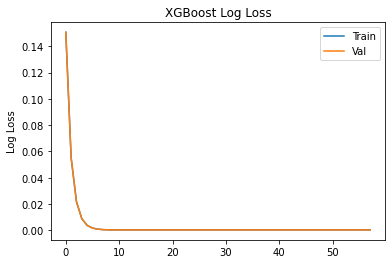

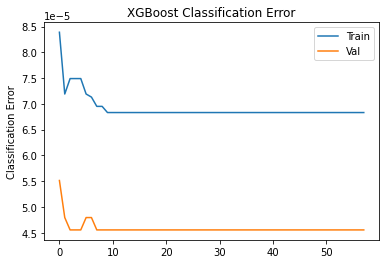

In [60]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [62]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

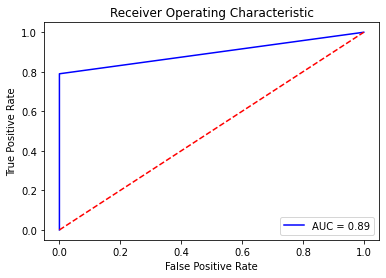

In [63]:
buildROC(y_test,y_pred)

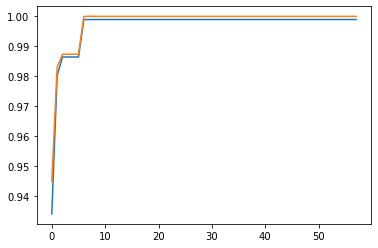

In [64]:
plt.plot(x_axis, results["validation_0"]["auc"], label="training data")
plt.plot(x_axis, results["validation_1"]["auc"], label="val data")


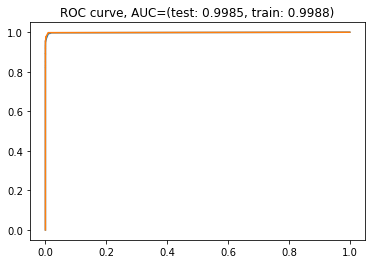

In [68]:
from sklearn import metrics
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_proba_test[:, 1])
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_proba_train[:, 1])

auc_test = metrics.auc(fpr_test, tpr_test)
auc_train = metrics.auc(fpr_train, tpr_train)

plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot(fpr_train, tpr_train, label="train data")

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(X_valid[target].values, check)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

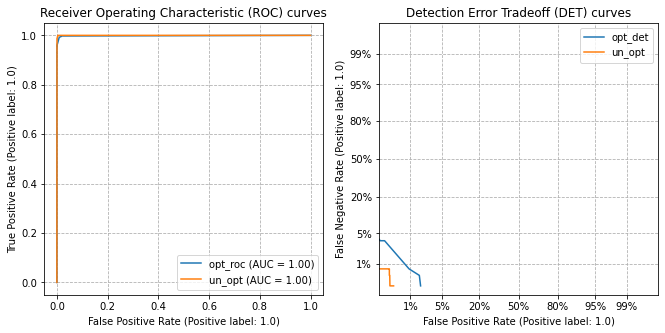

In [73]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc, name='opt_roc')
DetCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_det, name='opt_det')

RocCurveDisplay.from_estimator(unoptimised_model, X_test, y_test, ax=ax_roc, name="un_opt")
DetCurveDisplay.from_estimator(unoptimised_model, X_test, y_test, ax=ax_det, name="un_opt")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

In [79]:
X_test

,SOMATIC_vs,ID_vs,SPV_vs,FILTER_PASS_vs,SOMATIC_fb,QUAL_fb,ID_fb,QR_fb,DPB_fb,FILTER_PASS_m2,...,MQ_m2,FILTER_t_lod_fstar_m2,HCNT_m2,DP_m2,FILTER_PASS_vd,STATUS_vd,ID_vd,SSF_vd,VD_vd,SOMATIC_vd
1494288,0.0,2159986.0,191068.0,0.0,0.0,22038.0,2165990.0,1.0,69.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,2130487.0,70199.0,26.0,0.0
1381501,0.0,3310562.0,156860.0,0.0,0.0,10068.0,3333831.0,650.0,54.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,3264397.0,56675.0,15.0,0.0
4053437,0.0,3748485.0,117183.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3425792,0.0,744352.0,174374.0,0.0,0.0,27235.0,759437.0,50.0,122.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,741171.0,5463.0,44.0,0.0
251187,0.0,2387817.0,191068.0,0.0,0.0,24584.0,2397155.0,1.0,76.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,2356353.0,70199.0,36.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482420,0.0,1111101.0,174880.0,0.0,0.0,4035.0,1125137.0,779.0,49.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,1098042.0,34836.0,8.0,0.0
1195445,0.0,2115969.0,191068.0,0.0,0.0,23131.0,2121843.0,1.0,72.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,2087238.0,52702.0,35.0,0.0
1551394,0.0,581354.0,158732.0,0.0,0.0,6463.0,590510.0,1404.0,63.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,576725.0,35880.0,15.0,0.0
652021,0.0,1020809.0,191068.0,0.0,0.0,31319.0,1033555.0,1.0,102.0,NaN,...,NaN,NaN,NaN,NaN,0.0,2.0,1008034.0,70199.0,44.0,0.0


In [ ]:
model

In [69]:
# test on real2Part1

real2_varscan_sub = allel.vcf_to_dataframe("real2_part1/real2_varscan_chr1to5.vcf.gz", fields = final_target_features['varscan'])

real2_freebayes_sub = allel.vcf_to_dataframe("real2_part1/real2_freebayes_chr1to5.vcf.gz", fields = final_target_features['freebayes'])

real2_mutect2_sub = allel.vcf_to_dataframe("real2_part1/real2_mutect_chr1to5.vcf.gz", fields =final_target_features['mutect2'])

real2_vardict_sub = allel.vcf_to_dataframe("real2_part1/real2_vardict_chr1to5.vcf.gz", fields = final_target_features['vardict'])

In [72]:
real2_varscan_sub.is_snp == True

0       False
1       False
2       False
3       False
4        True
        ...  
2913     True
2914    False
2915     True
2916     True
2917     True
Name: is_snp, Length: 1772390, dtype: bool

In [ ]:
# subsetting for snp = True 
varscan_sub2 = real2_varscan_sub[real2_varscan_sub.is_snp == True]
freebayes_sub2 = real2_freebayes_sub[real2_freebayes_sub.is_snp == True]
mutect2_sub2 = real2_mutect2_sub[real2_mutect2_sub.is_snp == True]
vardict_sub2 = real2_vardict_sub[real2_vardict_sub.is_snp == True]

In [ ]:
lst_dfs = [varscan_sub2,freebayes_sub2,mutect2_sub2,vardict_sub2]
suffix = ['vs','fb','m2','vd']
keep_same = {'CHROM', 'POS'}
i =0 
for df in lst_dfs:
    df.columns = ['{}{}'.format(c, '' if c in keep_same else '_'+suffix[i]) for c in df.columns]
    i += 1
lst_dfs

In [ ]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score


In [32]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.629185830986374, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=97.89036584265726, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.9093539899332748, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=336, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

f1_score

[[1396415      23]
 [     89     279]]


0.8328358208955225

In [37]:
precision_score

0.9238410596026491

In [38]:
recall_score

0.7581521739130435

In [34]:
unoptimised_model = XGBClassifier(eval_metric = 'auc')

In [35]:
unoptimised_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [36]:
y_pred_u = unoptimised_model.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred_u))

f1_score_u = metrics.f1_score(y_true = y_test, y_pred = y_pred_u)
precision_score_u = metrics.precision_score(y_true = y_test, y_pred = y_pred_u)
recall_score_u = metrics.recall_score(y_true = y_test, y_pred = y_pred_u)

f1_score_u


[[1396401      37]
 [     46     322]]


0.8858321870701513

In [24]:
y_pred = model.predict(X_test)
# evaluate model performance # for syn1 dataset 
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1396415      23]
 [     89     279]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.92      0.76      0.83       368

    accuracy                           1.00   1396806
   macro avg       0.96      0.88      0.92   1396806
weighted avg       1.00      1.00      1.00   1396806



In [ ]:
# ROC curve plot


In [ ]:
 search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100)}

In [21]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

In [ ]:
# Running the optimizer # using the first search space

overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (1 hours)

best_param4s = report_perf(baye_opt, X_train, y_train,'XGBoost_classifier', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
The value of AUC using default hyperparameter values is 0.68, which is not bad
The tuned model AUC is 0.7416419 which is much higher than the model with default paraeters. Yeah, we have improved the model by tuning the parameters.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

In [ ]:
We can now get the folds using our train set. I use a repeated k-fold to get more score results:

In [ ]:
cv    = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,test) for train, test in cv.split(X_train, y_train)]

In [ ]:
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(X_train.iloc[train,:], label=y_train.iloc[train])
    dval   = xgb.DMatrix(X_train.iloc[test,:], label=y_train.iloc[test])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))

In [ ]:
model = XGBClassifier(n_estimators= 1000, eval_metric='rmse') # learning_rate = 0.5

In [ ]:
# shld prob change test to val
model.fit(X_train, y_train, early_stopping_rounds = 5, 
         eval_set=[(X_test, y_test)])

In [ ]:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# evaluate model performance # for syn1 dataset 
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
# evaluate model performance # for real1 dataset 
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
# 

In [ ]:
# partition training and validation sets


In [ ]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

In [ ]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        # 'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")
    
# Fit the model
result = bayes_cv_tuner.fit(X.values, y.values, callback=status_print)



In [ ]:
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(new_X, y, feature_names=X.columns.values) # new_X is an array 

In [ ]:
dtrain.get_label()

In [ ]:
new_X = pd.DataFrame(new_X, columns = X.columns.values )

In [ ]:
from sklearn.metrics import r2_score
# Define R-squared 
def xgb_r2(preds,dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(preds, labels)

# Objective Function
def hyp_xgb(max_depth, subsample, colsample_bytree,min_child_weight, gamma ):
    params = {
    'n_estimators': 300,
    'eta': 0.05,
    'objective': 'reg:squarederror',
    'eval_metric':'mae', # Optional --> Use eval_metric if you want to stop evaluation based on eval_metric 
    'silent': 1
     }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    scores = xgb.cv(params, dtrain, num_boost_round=1000,verbose_eval=False, early_stopping_rounds=10, custom_metric=xgb_r2, maximize=True, nfold=5)
    return  scores['test-r2-mean'].iloc[-1]


In [ ]:
pds ={
  'min_child_weight':(14, 20),
  'gamma':(0, 5),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (5, 10)
}
# Surrogate model
optimizer = BayesianOptimization(hyp_xgb, pds, random_state=10)
                                  
# Optimize
optimizer.maximize(init_points=5, n_iter=15)

In [ ]:
# Classifier/Regressor
from xgboost import XGBRegressor, DMatrix
from functools import partial
# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [ ]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

In [ ]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True, 
                      random_state=0)

cv_strategy = list(skf.split(X_train, y_train))

In [ ]:
# Setting the basic regressor
reg = XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='hist')

In [ ]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
                }